In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\StradVision\anaconda3\envs\py39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\StradVision\anaconda3\envs\py39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
path2data = './data'
os.makedirs(path2data, exist_ok=True) # 폴더 생성
                                      # exist_ok option! 폴더 없으면 생성

In [3]:
# MNIST dataset 불러오기
train_ds = datasets.MNIST(path2data, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]), download=True)

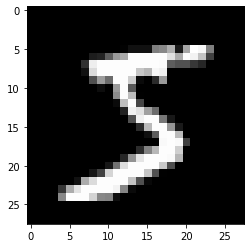

In [4]:
img, label = train_ds[0]
plt.imshow(to_pil_image(0.5*img+0.5), cmap='gray') 
#denormalize하는 부분, normalize -> (x-mean)/std
#img type : torch.Tensor
#to_pil_image : tensor를 이미지로 

In [5]:
#데이터 로더 생성
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [6]:
#check
for x, y in train_dl:
    print(x.shape, y.shape)
    break

#x.shape : torch.Size([32, 1, 28, 28]) = (batch_size, channel, width, height)
#y.shape : torch.Size([32]) = label

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [7]:
#generator : noise를 입력받아 이미지를 생성
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz'] #입력 노이즈 벡터 수, 100
        self.img_size = params['img_size'] #이미지 크기, 1x28x28
        
        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize=False),
            *self._fc_layer(128, 256),
            *self._fc_layer(256, 512),
            *self._fc_layer(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_size))), #Linear(in_features=1024, out_features=784, bias=True)
            nn.Tanh()
        )
    #np.prod() : axis를 기준으로 array 내부 elements들의 곱
    #https://aigong.tistory.com/47
        
        
    def forward(self, z):
        img = self.model(z) #위에서 선언한 모델에 z <- 파라미터 입력 (torch.Size([16, 100]))
        img = img.view(img.size(0), *self.img_size) #torch.Size([16, 1, 28, 28])
        #img.size(0) = 16
        #*self.img_size = 1 28 28
        #즉, img.view(img.size(0), *self.img_size) = img.view(16, 1, 28, 28)
        return img
    
    #__init__()에서 사용할 네트워크 모델들을 정의, 
    #forward() 함수에서는 그 모델들을 사용하여 순전파 로직 구현
    
    #fc layer
    def _fc_layer(self, in_channels, out_channels, normalize=True): # <-- __init__ (모델 선언)에 사용
        layers = []
        layers.append(nn.Linear(in_channels, out_channels)) #fc layer
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        return layers
    
    #layer 정의
    # [Linear(in_features=100, out_features=128, bias=True), LeakyReLU(negative_slope=0.2)]
    # [Linear(in_features=128, out_features=256, bias=True), BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2)]
    # [Linear(in_features=256, out_features=512, bias=True), BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2)]
    # [Linear(in_features=512, out_features=1024, bias=True), BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2)]
    
    #normalize=False일때는 LeakyReUL만 통과
    #default normalize는 True -> BatchNorm1d, LeakyReLU 모두 통과
    
#check
params = {'nz':100, 'img_size':(1,28,28)} #노이즈 벡터 수, 이미지 크기 저장
x = torch.randn(16, 100).to(device) #x.shape : torch.Size([16, 100])
model_gen = Generator(params).to(device) #params 전달해주고 모델 선언
output = model_gen(x) #모델에 input 넣어주기
print(output.shape)


torch.Size([16, 1, 28, 28])


In [8]:
import numpy as np
import torch

t = np.zeros((4,4,3)) #0으로 채워진 4x4x3 numpy array 생성
ft = torch.FloatTensor(t) #텐서로 변환
print(ft.shape) #torch.Size([4,4,3]) = (batch, w, h)
print(ft.view([-1, 3]).shape) #텐서를 (?, 3) 크기로 변경
# 원소의 개수 (4x4x3 = 48) 유지한 채 3차원을 맞추니깐 결론적으로 16x3

torch.Size([4, 4, 3])
torch.Size([16, 3])


In [16]:
#discriminator : 진짜 이미지와 가짜 이미지를 분류
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.img_size = params['img_size'] #1x28x28 (28x28 = 784)
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        #x.shape : torch.Size([16, 1, 28, 28])
        x = x.view(x.size(0), -1)
        #x.shape : torch.Size([16, 784])
        x = self.model(x)
        #x.shape : torch.Size([16, 1])
        return x
        #batch size 개수에 맞게 결과 반환. 그래서 위에서 view(x.size(0), -1) 한거임!

#check
#params = {'nz':100, 'img_size':(1,28,28)} #노이즈 벡터 수, 이미지 크기 저장
x = torch.randn(16,1,28,28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape) #torch.Size([16, 1]) : 하나의 값으로 나오는데, 16장 넣어줬으니깐 (16, 1)
        

torch.Size([16, 1])


In [28]:
#가중치 초기화
def initialize_weights(model):
    #클래스 이름 가져오기 
    classname = model.__class__.__name__ 
    #fc layer
    if classname.find('Linear') != -1: #linear layer에서
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    #batchnorm
    elif classname.find('BatchNorm') != -1: #batchnorm layer에서 
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

#가중치 초기화 적용
model_gen.apply(initialize_weights);

# Generator(
#   (model): Sequential(
#     (0): Linear(in_features=100, out_features=128, bias=True)
#     (1): LeakyReLU(negative_slope=0.2)
#     (2): Linear(in_features=128, out_features=256, bias=True)
#     (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
#     (4): LeakyReLU(negative_slope=0.2)
#     (5): Linear(in_features=256, out_features=512, bias=True)
#     (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
#     (7): LeakyReLU(negative_slope=0.2)
#     (8): Linear(in_features=512, out_features=1024, bias=True)
#     (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
#     (10): LeakyReLU(negative_slope=0.2)
#     (11): Linear(in_features=1024, out_features=784, bias=True)
#     (12): Tanh()
#   )
# )


model_dis.apply(initialize_weights)

# Discriminator(
#   (model): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): LeakyReLU(negative_slope=0.2)
#     (2): Linear(in_features=512, out_features=256, bias=True)
#     (3): LeakyReLU(negative_slope=0.2)
#     (4): Linear(in_features=256, out_features=1, bias=True)
#     (5): Sigmoid()
#   )
# )
    
    

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [29]:
class num:
    def __init__(self, num):
        self.num = num
x = num(1)
print (x.__class__)
print (x.__class__.__name__)

<class '__main__.num'>
num


In [30]:
#loss 함수
loss_func = nn.BCELoss() 
#bce loss는 마지막 레이어 노드 수가 "1"일때, 
#그리고 그 값이 0 ~ 1 일때
#그래서 마지막에 시그모이드 함수 적용시켜줘야함

In [32]:
from torch import optim

#최적화 파라미터
lr = 2e-4
beta1 = 0.5

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1, 0.999))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,0.999))

In [33]:
real_label = 1.
fake_label = 0.
nz = params['nz']
num_epochs = 2

loss_history={'gen':[], 'dis':[]}

In [42]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        batch_size = xb.size(0) 

        xb = xb.to(device)
        yb_real = torch.Tensor(batch_size,1).fill_(1.0).to(device) #shape : torch.Size([32, 1])
        yb_fake = torch.Tensor(batch_size,1).fill_(0.0).to(device)
        
        
        #Generator
        model_gen.zero_grad()
        noise = torch.randn(batch_size, nz, device=device)
        out_gen = model_gen(noise)
        out_dis = model_dis(out_gen)
        
        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()
        
        #Discriminator
        model_dis.zero_grad()
        
        out_real = model_dis(xb)
        out_fake = model_dis(out_gen.detach()) #????
        loss_real = loss_func(out_real, yb_real)
        loss_fake = loss_func(out_fake, yb_fake)
        loss_dis = (loss_real + loss_fake) / 2
        
        loss_dis.backward()
        opt_dis.step()
        
        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())
        
        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))
        
        

Epoch: 0, G_Loss: 3.882687, D_Loss: 0.709129, time: 0.18 min
Epoch: 1, G_Loss: 1.654941, D_Loss: 0.481597, time: 0.36 min
Epoch: 1, G_Loss: 1.884708, D_Loss: 0.146628, time: 0.55 min


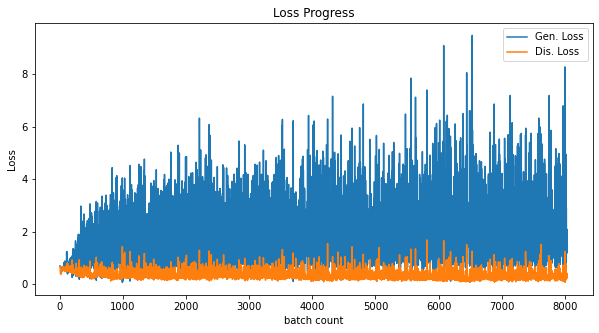

In [43]:
#plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
#가중치 저장
path2models = './models'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)  

In [46]:
#가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

#evaluation mode
model_gen.eval()

#가짜 이미지 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


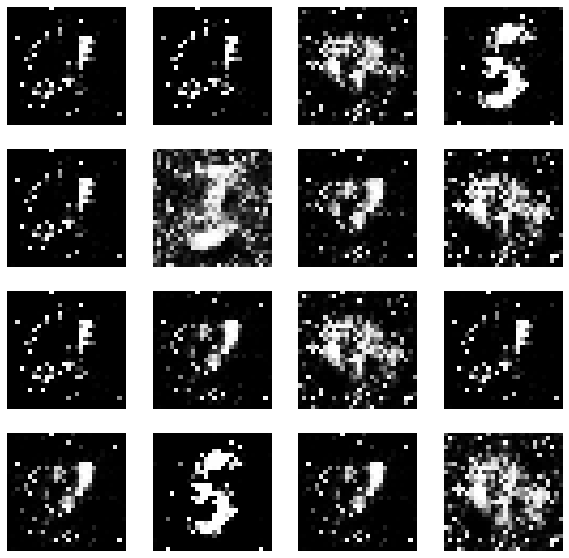

In [55]:
#가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),cmap='gray')
    plt.axis('off') #좌표표시 off